In [5]:
import os
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

**Utility plotting method**

In [6]:
def plot_df(df, column=None, ax=None, alpha=0.5,crs=3857):
    "Plot based on the `geometry` column of a GeoPandas dataframe"
    df = df.copy()
    df = df.to_crs(epsg=crs)  # web mercator

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(
        ax=ax,
        alpha=alpha, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'},
    )
    cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)


def plot_shape(shape, ax=None, crs=3857):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax, crs=crs)


## Natural Earth Downloads

Source for geographic boundaries for countries, subunits like the Continental United States, states and provinces, and counties. Used to define geometric filters when querying OSM, as well as matching and assigning reviews to geolocated wineries.

In [7]:
ne_base_url = 'https://naciscdn.org/naturalearth/10m/cultural/'
local_path = 'data/'


def ne_load(file, url=ne_base_url, path=local_path):
  target = path+file.replace('.zip', '')

  # download the file if necessary
  if not os.path.exists(target):
    zipurl = url+file
    with urlopen(zipurl) as zipresp:
      with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall(target)

  # make sure the file exists
  assert os.path.exists(target)

  # return the file as a panda frame
  return gpd.read_file(target)

In [8]:
ne_cols = ['SOVEREIGNT', 'ADMIN', 'GEOUNIT', 'TYPE', 'NAME', 'NAME_LONG', 'ABBREV', 'FORMAL_EN', 'NAME_SORT', 'ISO_A2_EH', 'CONTINENT', 'SUBREGION', 'REGION_UN', 'geometry']
def load_countries(path=local_path):
  return ne_load('ne_10m_admin_0_map_units.zip', path)[ne_cols]

def load_subunits(path=local_path):
  cols = ne_cols.copy()
  cols.insert(3, 'SUBUNIT')
  return ne_load('ne_10m_admin_0_map_subunits.zip', path)[cols]

def load_provinces(path=local_path):
  cols = ['iso_a2', 'name', 'type', 'type_en', 'region', 'abbrev', 'admin', 'geonunit', 'region_sub', 'name_en', 'postal', 'geometry']
  return ne_load('ne_10m_admin_1_states_provinces.zip', path)[cols]

def load_counties(path=local_path):
  cols = ['ISO_A2', 'NAME', 'TYPE', 'TYPE_EN', 'CODE_LOCAL', 'REGION', 'ADMIN', 'GEONUNIT', 'NAME_EN', 'geometry']
  return ne_load('ne_10m_admin_2_counties.zip', path)[cols]

In [9]:
countries = load_countries()
countries.head()

,SOVEREIGNT,ADMIN,GEOUNIT,TYPE,NAME,NAME_LONG,ABBREV,FORMAL_EN,NAME_SORT,ISO_A2_EH,CONTINENT,SUBREGION,REGION_UN,geometry
0,Indonesia,Indonesia,Indonesia,Sovereign country,Indonesia,Indonesia,Indo.,Republic of Indonesia,Indonesia,ID,Asia,South-Eastern Asia,Asia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,Malaysia,Malaysia,Sovereign country,Malaysia,Malaysia,Malay.,Malaysia,Malaysia,MY,Asia,South-Eastern Asia,Asia,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,Chile,Chile,Sovereign country,Chile,Chile,Chile,Republic of Chile,Chile,CL,South America,South America,Americas,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Bolivia,Bolivia,Bolivia,Sovereign country,Bolivia,Bolivia,Bolivia,Plurinational State of Bolivia,Bolivia,BO,South America,South America,Americas,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Peru,Peru,Peru,Sovereign country,Peru,Peru,Peru,Republic of Peru,Peru,PE,South America,South America,Americas,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [10]:
countries[countries.SOVEREIGNT=='United States of America']

,SOVEREIGNT,ADMIN,GEOUNIT,TYPE,NAME,NAME_LONG,ABBREV,FORMAL_EN,NAME_SORT,ISO_A2_EH,CONTINENT,SUBREGION,REGION_UN,geometry
165,United States of America,United States of America,United States of America,Country,United States of America,United States,U.S.A.,United States of America,United States of America,US,North America,Northern America,Americas,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532..."
223,United States of America,United States Minor Outlying Islands,Johnston Atoll,Geo unit,Johnston Atoll,Johnston Atoll,John. At.,None,Johnston Atoll,US,Oceania,Micronesia,Oceania,"MULTIPOLYGON (((-169.53026 16.7602, -169.52082..."
228,United States of America,United States Virgin Islands,United States Virgin Islands,Dependency,U.S. Virgin Is.,United States Virgin Islands,V.I. (U.S.),Virgin Islands of the United States,Virgin Islands (U.S.),VI,North America,Caribbean,Americas,"MULTIPOLYGON (((-64.5594 17.75161, -64.58519 1..."
230,United States of America,Puerto Rico,Puerto Rico,Dependency,Puerto Rico,Puerto Rico,P.R.,Commonwealth of Puerto Rico,Puerto Rico,PR,North America,Caribbean,Americas,"MULTIPOLYGON (((-67.85587 18.11469, -67.84435 ..."
274,United States of America,American Samoa,American Samoa,Dependency,American Samoa,American Samoa,Am. Samoa,American Samoa,American Samoa,AS,Oceania,Polynesia,Oceania,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576..."
276,United States of America,Guam,Guam,Dependency,Guam,Guam,Guam,Territory of Guam,Guam,GU,Oceania,Micronesia,Oceania,"POLYGON ((144.8864 13.6402, 144.89666 13.61799..."
277,United States of America,Northern Mariana Islands,Northern Mariana Islands,Dependency,N. Mariana Is.,Northern Mariana Islands,N.M.I.,Commonwealth of the Northern Mariana Islands,Northern Mariana Islands,MP,Oceania,Micronesia,Oceania,"MULTIPOLYGON (((145.20574 14.18138, 145.25245 ..."
283,United States of America,United States Minor Outlying Islands,Jarvis Island,Geo unit,Jarvis I.,Jarvis Island,Jar. I.,None,Jarvis Island,US,Oceania,Micronesia,Oceania,"POLYGON ((-160.02998 -0.37615, -160.0089 -0.37..."
284,United States of America,United States Minor Outlying Islands,Baker Island,Geo unit,Baker I.,Baker Island,Baker I.,None,Baker Island,US,Oceania,Micronesia,Oceania,"MULTIPOLYGON (((-176.48583 0.19652, -176.48213..."
285,United States of America,United States Minor Outlying Islands,Howland Island,Geo unit,Howland I.,Howland Island,How. I.,None,Howland Island,US,Oceania,Micronesia,Oceania,"POLYGON ((-176.63618 0.79019, -176.64049 0.801..."


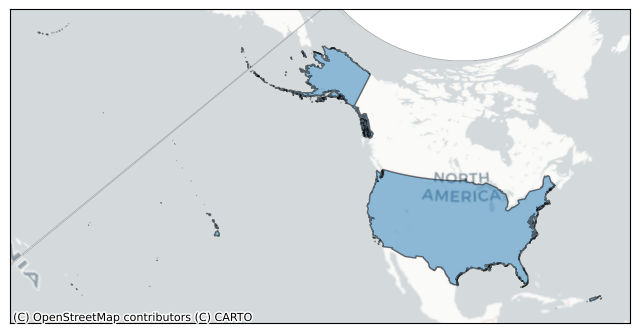

In [11]:
plot_df(gpd.GeoDataFrame(geometry=countries[countries.SOVEREIGNT=='United States of America'].geometry), crs=6350)

In [12]:
subunits = load_subunits()
subunits.head()

,SOVEREIGNT,ADMIN,GEOUNIT,SUBUNIT,TYPE,NAME,NAME_LONG,ABBREV,FORMAL_EN,NAME_SORT,ISO_A2_EH,CONTINENT,SUBREGION,REGION_UN,geometry
0,Indonesia,Indonesia,Indonesia,Indonesia,Sovereign country,Indonesia,Indonesia,Indo.,Republic of Indonesia,Indonesia,ID,Asia,South-Eastern Asia,Asia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,Malaysia,Malaysia,Malaysia,Sovereign country,Malaysia,Malaysia,Malay.,Malaysia,Malaysia,MY,Asia,South-Eastern Asia,Asia,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,Chile,Chile,Chile,Geo subunit,Chile,Chile,Chile,Republic of Chile,Chile,CL,South America,South America,Americas,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Bolivia,Bolivia,Bolivia,Bolivia,Sovereign country,Bolivia,Bolivia,Bolivia,Plurinational State of Bolivia,Bolivia,BO,South America,South America,Americas,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Peru,Peru,Peru,Peru,Sovereign country,Peru,Peru,Peru,Republic of Peru,Peru,PE,South America,South America,Americas,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [13]:
subunits[subunits.GEOUNIT=='United States of America']

,SOVEREIGNT,ADMIN,GEOUNIT,SUBUNIT,TYPE,NAME,NAME_LONG,ABBREV,FORMAL_EN,NAME_SORT,ISO_A2_EH,CONTINENT,SUBREGION,REGION_UN,geometry
170,United States of America,United States of America,United States of America,United States,Geo subunit,United States of America,United States of America,U.S.A.,United States of America,United States of America,US,North America,Northern America,Americas,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532..."
182,United States of America,United States of America,United States of America,Alaska,Geo subunit,Alaska,Alaska,Alaska,None,Alaska,US,North America,Northern America,Americas,"MULTIPOLYGON (((-141.00556 69.65095, -141.0054..."
292,United States of America,United States of America,United States of America,Hawaii,Geo subunit,Hawaii,Hawaii,Hawaii,None,Hawaii,US,Oceania,Polynesia,Oceania,"MULTIPOLYGON (((-154.89962 19.56702, -154.8466..."


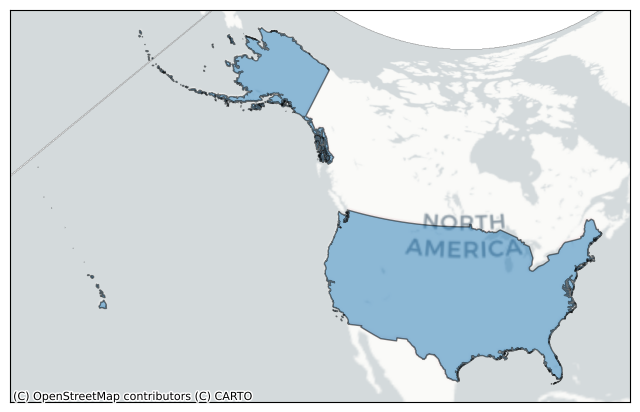

In [14]:
plot_df(gpd.GeoDataFrame(geometry=subunits[subunits.GEOUNIT=='United States of America'].geometry), crs=6350)

In [15]:
provinces = load_provinces()
provinces.head()

,iso_a2,name,type,type_en,region,abbrev,admin,geonunit,region_sub,name_en,postal,geometry
0,AR,Entre Ríos,Provincia,Province,None,None,Argentina,Argentina,None,Entre Ríos,ER,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,UY,Paysandú,Departamento,Department,None,None,Uruguay,Uruguay,None,Paysandú,PA,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,ID,Kalimantan Timur,Propinsi,Province,None,None,Indonesia,Indonesia,None,East Kalimantan,KI,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
3,MY,Sabah,State,State,None,None,Malaysia,Malaysia,None,Sabah,SA,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
4,CL,Arica y Parinacota,Región,Region,None,None,Chile,Chile,None,Arica y Parinacota,None,"POLYGON ((-69.51009 -17.50659, -69.50611 -17.5..."


In [16]:
provinces[provinces.admin=='United States of America']

,iso_a2,name,type,type_en,region,abbrev,admin,geonunit,region_sub,name_en,postal,geometry
1235,US,Washington,State,State,West,Wash.,United States of America,United States of America,Pacific,Washington,WA,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532..."
1237,US,Idaho,State,State,West,Idaho,United States of America,United States of America,Mountain,Idaho,ID,"POLYGON ((-117.03815 48.99251, -116.93818 48.9..."
1238,US,Montana,State,State,West,Mont.,United States of America,United States of America,Mountain,Montana,MT,"POLYGON ((-116.04816 48.99251, -115.83913 48.9..."
1241,US,North Dakota,State,State,Midwest,N.D.,United States of America,United States of America,West North Central,North Dakota,ND,"POLYGON ((-104.04757 48.99262, -103.96949 48.9..."
1243,US,Minnesota,State,State,Midwest,Minn.,United States of America,United States of America,West North Central,Minnesota,MN,"POLYGON ((-97.22609 48.99267, -97.15538 48.992..."
1245,US,Michigan,State,State,Midwest,Mich.,United States of America,United States of America,East North Central,Michigan,MI,"POLYGON ((-89.49896 47.99509, -89.46185 47.994..."
1246,US,Ohio,State,State,Midwest,Ohio,United States of America,United States of America,East North Central,Ohio,OH,"POLYGON ((-83.13086 41.93803, -83.12345 41.920..."
1247,US,Pennsylvania,State,State,Northeast,Pa.,United States of America,United States of America,Middle Atlantic,Pennsylvania,PA,"POLYGON ((-80.52023 42.32378, -80.50415 42.326..."
1248,US,New York,State,State,Northeast,N.Y.,United States of America,United States of America,Middle Atlantic,New York,NY,"MULTIPOLYGON (((-79.76301 42.5377, -79.63302 4..."
1250,US,Vermont,State,State,Northeast,Vt.,United States of America,United States of America,New England,Vermont,VT,"POLYGON ((-73.35134 45.00463, -73.29942 45.004..."


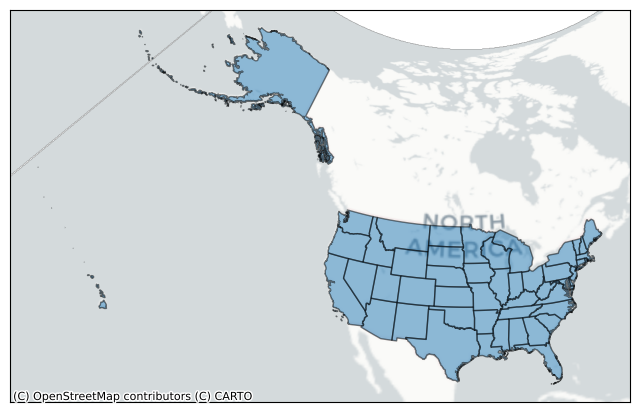

In [17]:
plot_df(gpd.GeoDataFrame(geometry=provinces[provinces.admin=='United States of America'].geometry), crs=6350)

In [18]:
counties = load_counties()
counties.head()

,ISO_A2,NAME,TYPE,TYPE_EN,CODE_LOCAL,REGION,ADMIN,GEONUNIT,NAME_EN,geometry
0,US,Whatcom,County,County,53073,WA,United States of America,United States of America,Whatcom,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532..."
1,US,Okanogan,County,County,53047,WA,United States of America,United States of America,Okanogan,"POLYGON ((-120.85196 48.99251, -120.67495 48.9..."
2,US,Ferry,County,County,53019,WA,United States of America,United States of America,Ferry,"POLYGON ((-118.83688 48.99251, -118.69668 48.9..."
3,US,Stevens,County,County,53065,WA,United States of America,United States of America,Stevens,"POLYGON ((-118.21996 48.99251, -118.03723 48.9..."
4,US,Pend Oreille,County,County,53051,WA,United States of America,United States of America,Pend Oreille,"POLYGON ((-117.42951 48.99251, -117.37787 48.9..."


In [19]:
counties[counties.REGION == 'CA']

,ISO_A2,NAME,TYPE,TYPE_EN,CODE_LOCAL,REGION,ADMIN,GEONUNIT,NAME_EN,geometry
78,US,Imperial,County,County,06025,CA,United States of America,United States of America,Imperial,"POLYGON ((-114.72428 32.71284, -114.76454 32.7..."
79,US,San Diego,County,County,06073,CA,United States of America,United States of America,San Diego,"POLYGON ((-116.1054 32.60838, -116.16174 32.60..."
335,US,Del Norte,County,County,06015,CA,United States of America,United States of America,Del Norte,"POLYGON ((-124.06932 41.46371, -124.07608 41.4..."
336,US,Humboldt,County,County,06023,CA,United States of America,United States of America,Humboldt,"POLYGON ((-124.02271 40.00214, -124.03346 40.0..."
337,US,Mendocino,County,County,06045,CA,United States of America,United States of America,Mendocino,"POLYGON ((-123.53764 38.77233, -123.55885 38.7..."
338,US,Sonoma,County,County,06097,CA,United States of America,United States of America,Sonoma,"POLYGON ((-123.00228 38.29486, -123.02952 38.3..."
339,US,Marin,County,County,06041,CA,United States of America,United States of America,Marin,"POLYGON ((-122.52843 37.81637, -122.53795 37.8..."
340,US,Solano,County,County,06095,CA,United States of America,United States of America,Solano,"POLYGON ((-121.68768 38.14745, -121.68948 38.1..."
341,US,Sacramento,County,County,06067,CA,United States of America,United States of America,Sacramento,"POLYGON ((-121.57128 38.09714, -121.5865 38.10..."
342,US,San Joaquin,County,County,06077,CA,United States of America,United States of America,San Joaquin,"POLYGON ((-121.58248 38.03578, -121.58021 38.0..."


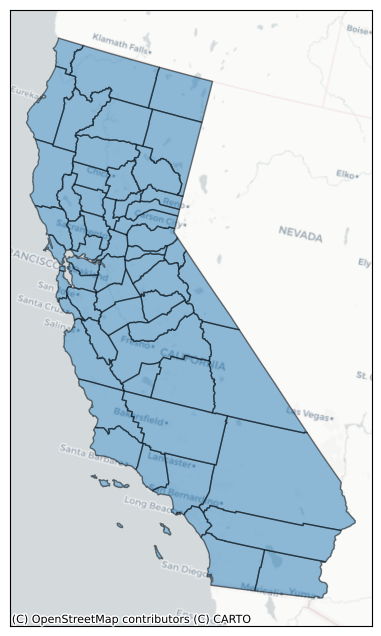

In [20]:
plot_df(gpd.GeoDataFrame(geometry=counties[counties.REGION == 'CA'].geometry), crs=6350)